# Load Intention Checkpoint and Rendering

This notebook will load the training checkpoint from the intention network and do a rendering of the rollout. 

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import logging
from tqdm import tqdm
# Send logging outputs to stdout (comment this out if preferred)
# logger = logging.getLogger()
# logger.setLevel(logging.INFO)

# Change this to egl or glfw if available
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # visible GPU masks
os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"


from track_mjx.agent import checkpointing
from vnl_mjx.tasks.rodent import flat_arena, bowl_escape
import mediapy as media
import numpy as np
import jax
from jax import numpy as jnp
import mediapy as media
import imageio
import mujoco as mj

from orbax import checkpoint as ocp

# enable JAX persistent compilation cache
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_persistent_cache_enable_xla_caches", "xla_gpu_per_fusion_autotune_cache_dir")

# replace with your checkpoint path
transfer_and_freeze = "/root/vast/scott-yang/vnl-mjx/model_checkpoints/250701_203400"
transfer_not_freeze = "/root/vast/scott-yang/vnl-mjx/model_checkpoints/250701_203433"
ckpt = checkpointing.load_checkpoint_for_eval(transfer_and_freeze)


# Load config from checkpoint
cfg = ckpt["cfg"]
# cfg["env_config"]["env_args"]["bowl_vsize"] = 0.3
env = bowl_escape.BowlEscape(config_overrides=cfg["env_config"]["env_args"])
jit_reset, jit_step = jax.jit(env.reset), jax.jit(env.step)


def render(model, data=None, height: int = 400, camera: int | str = -1, filename="render.png"):
    if data is None:
        data = mj.MjData(model)
    with mj.Renderer(model, 2160, 3840) as renderer:
        mj.mj_forward(model, data)
        renderer.update_scene(data, camera=camera)
        frame = renderer.render()
        media.show_image(frame, height=height)
        imageio.imwrite(filename, frame)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading checkpoint from /root/vast/scott-yang/vnl-mjx/model_checkpoints/250701_203400 at step 99
Initial position: 0.0, 0.0, 0.009999999776482582
Converting to torque actuators
Rescaling body tree with scale factor 0.9


In [2]:
# replace with your checkpoint path
ckpt_path = transfer_and_freeze
ckpt = checkpointing.load_checkpoint_for_eval(ckpt_path)

Loading checkpoint from /root/vast/scott-yang/vnl-mjx/model_checkpoints/250701_203400 at step 99


In [3]:
# once you compile the environment, you can easily swap the checkpoint
# and do the rollout and renderings
inference_fn = checkpointing.load_inference_fn(cfg, ckpt["policy"])
jit_inference_fn = jax.jit(inference_fn)

In [4]:
rng = jax.random.PRNGKey(1)

rng, reset_rng = jax.random.split(rng)
state = jit_reset(reset_rng)
rollout = [state]
for i in tqdm(range(2000)):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state)

/root/miniforge3/envs/track-mjx/lib/python3.11/site-packages/jax/_src/interpreters/xla.py:119: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))
100%|██████████| 2000/2000 [02:33<00:00, 13.06it/s] 


In [5]:
import mujoco

render_every = 2
fps = 1.0 / env.dt / render_every
traj = rollout[::render_every]

scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False

frames = env.render(
    traj,
    camera="close_profile-rodent",
    scene_option=scene_option,
    height=480,
    width=640,
)
media.show_video(frames, fps=fps, loop=False)
media.write_video(f"succ_escape.mp4", frames, fps=fps, qp=18)

100%|██████████| 1001/1001 [00:02<00:00, 378.37it/s]


In [10]:
rollout[3].data.qpos

Array([ 3.2791385e-04,  8.5423491e-04,  9.6237157e-03,  9.9997729e-01,
        6.3040419e-03, -2.1614158e-03, -1.0189596e-03,  5.5533005e-03,
       -1.3572150e-03, -1.0742908e-02,  2.2491829e-03,  2.0704776e-04,
       -7.3187649e-03,  1.3689646e-03,  1.3313983e-03, -2.3797401e-03,
        4.8839482e-03,  8.0043618e-03,  1.3418082e-04,  3.0956282e-05,
       -6.5847540e-05,  1.6689638e-03,  9.1149155e-03,  1.1606751e-02,
        2.0028015e-03, -1.6174720e-03, -3.9887987e-04, -1.0247186e-03,
       -5.1956329e-05, -6.5051793e-04,  7.1237635e-05, -4.2471563e-04,
        9.2707611e-05, -2.8669217e-04,  7.6497730e-05, -2.1695071e-04,
        6.2389299e-05, -1.6897400e-04, -8.6707129e-05, -2.5987929e-06,
       -2.2218122e-04,  3.4739649e-05, -1.8549472e-04,  3.1187796e-05,
       -1.1280659e-04,  1.7422304e-05, -4.3804495e-05,  5.2239470e-06,
       -6.1895589e-06,  6.9174607e-04,  4.3898140e-04, -1.0426980e-05,
        6.7154114e-04,  4.2350130e-04, -5.3184640e-06,  6.5760937e-04,
      

## Use the renderer environment

In [90]:
# Load config from checkpoint
cfg = ckpt["cfg"]
# cfg["env_config"]["env_args"]["bowl_vsize"] = 0.3
env = bowl_escape.BowlEscapeRender(
    num_rodents=20, config_overrides=cfg["env_config"]["env_args"]
)

Initial position: 0.0, 0.0, 0.009999999776482582
Converting to torque actuators
Rescaling body tree with scale factor 0.9
Initial position: 0.1, 0.1, 0.010568760335445404
Converting to torque actuators
Rescaling body tree with scale factor 0.9
Initial position: 0.2, 0.2, 0.012898794375360012
Converting to torque actuators
Rescaling body tree with scale factor 0.9
Initial position: 0.30000000000000004, 0.30000000000000004, 0.021283986046910286
Converting to torque actuators
Rescaling body tree with scale factor 0.9
Initial position: 0.4, 0.4, 0.027506394311785698
Converting to torque actuators
Rescaling body tree with scale factor 0.9
Initial position: 0.5, 0.5, 0.03960639610886574
Converting to torque actuators
Rescaling body tree with scale factor 0.9
Initial position: 0.6, 0.6, 0.059301622211933136
Converting to torque actuators
Rescaling body tree with scale factor 0.9
Initial position: 0.7, 0.7, 0.0764380693435669
Converting to torque actuators
Rescaling body tree with scale factor

""

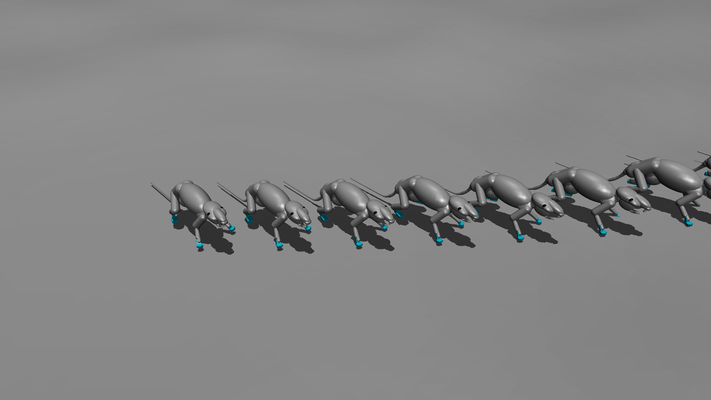

In [91]:
render(env.mj_model, height=400, camera="close_profile-rodent-2")

In [94]:
data = mujoco.MjData(env.mj_model)
start, stride, num_frames = 0, 50, 20
qposes = np.concatenate(
    [traj[i].data.qpos for i in np.arange(start, start + stride * num_frames, stride)],
    axis=0,
)
data.qpos = qposes

""

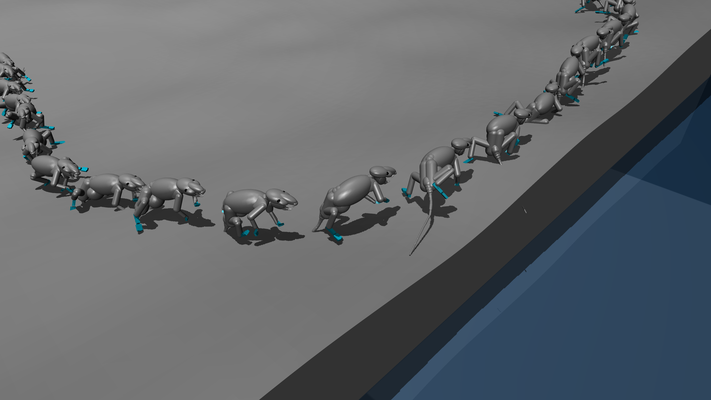

""

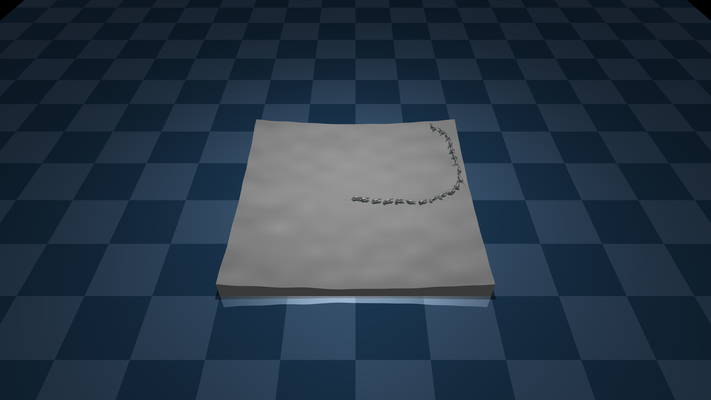

In [96]:
render(env.mj_model, data, height=400, camera="close_profile-rodent-10")
render(env.mj_model, data, height=400, camera=-1)